In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rnd
from scipy.ndimage import convolve
from tqdm import tqdm

class DBM_RDG:

    def __init__(self,
                 N = 40,
                 dimensions=None,
                 nu=1.5,
                 debug=False,
                 threshold = 0.0001):

        # Unless specified, expect grid of NxNxN dimension, in order z, x, y
        if dimensions is None:
            self.dim = {'height': N, 'width': N,'depth': N}
        else:
            self.dim = {'height': dimensions[0], 'width': dimensions[1],'depth': dimensions[2]}

        # Create encoding grid and set all to 0
        #  0 encodes unfixed potential
        #  anything else encodes fixed potential
        # (I also use this grid to track order of cells in lightning structure)
        self.fixed_grid = np.zeros(shape=list(self.dim.values()))

        # Set all boundaries to be fixed
        self.fixed_grid[:, :, 0] = -1  # front boundary
        self.fixed_grid[:, :, -1] = -1  # back boundary
        self.fixed_grid[:, 0, :] = -1  # left boundary
        self.fixed_grid[:, -1, :] = -1  # right boundary
        self.fixed_grid[0, :, :] = -1  # top boundary
        self.fixed_grid[-1, :, :] = -1  # bottom boundary

        # The electric potential
        self.potential = np.zeros(shape=list(self.dim.values()))

        # The lightning downwards-tendency parameter
        self.nu = nu

        # Number of update steps
        self.steps = 1

        # To debug or not
        self.debug = debug

        # Keep track of current neighbors of structure
        self.structure_neighbors = set()

        self.struck_ground = False

        self.threshold = threshold

        # Debugging lists
        self.difference_per_conv = []
        self.overall_sum = []

        # Neighborhood
        self.neighbors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), 
                         (-1, 0, 0), (0,-1, 0), (0, 0,-1)]
        
        # Setup initial electric potential
        self.initial_electric_pot()

        # Add the first cell as a structure neighbor
        self.structure_neighbors.add((0, self.dim['width']//2, self.dim['depth']//2))
        # Update structure with that cell
        self.expand_lightning_to((0, self.dim['width']//2, self.dim['depth']//2))

        self.steps += 1


    def strike_lightning(self):

        # Run update until lightning strikes ground
        self.struck_ground = False

        # Create a tqdm tracker
        if self.debug:
            progress_bar = tqdm(total=self.dim['height'], desc="How close the lightning is to the ground", unit="iter")

        while not self.struck_ground:
            # Update lightning
            self.update()

            if self.debug:
                # If the newly added cell made the lightning stretch one step lower, update dist_to_ground
                if self.dim['height'] - self.newest_neighbor[0] < self.dist_to_ground:
                    self.dist_to_ground = self.dim['height'] - self.newest_neighbor[0]
                    progress_bar.update(1)

    def update(self):

        weights = []
        # For each structure neighbor
        for neighbor_pos in self.structure_neighbors:
            # Raise each weight to the power of nu
            weights.append(self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] ** self.nu)
        
        # Choose a random neighbor with the weighting
        chosen_cell = rnd.choices(list(self.structure_neighbors), weights)[0]

        # Update lightning grid, potential and newest neighbor
        self.expand_lightning_to(chosen_cell)

        self.steps += 1

    def initial_electric_pot(self):

        # Create a linear gradient along the depth axis
        gradient = np.linspace(0, 1, self.dim['height'])[:, np.newaxis, np.newaxis]

        # Apply the gradient to the array
        self.potential += gradient



    def expand_lightning_to(self, pos):
        '''
        Updates correpsonding grids
        Update neighborhood of lightning structure
        Call method to update electric potential
        '''

        self.newest_neighbor = pos

        # Remove the potential
        self.potential[pos[0], pos[1], pos[2]] = 0

        # Set it as a fixed cell
        self.fixed_grid[pos[0], pos[1], pos[2]] = self.steps

        # Update structure neighbors
        self.structure_neighbors.remove(pos)
        for neighbor_delta in self.neighbors:
            neighbor_pos = (pos[0] + neighbor_delta[0], pos[1] + neighbor_delta[1], pos[2] + neighbor_delta[2])
            if neighbor_pos[0] == self.dim['height']:
                self.struck_ground = True
                break

            if neighbor_pos[0] >= 0 and neighbor_pos[0] < self.dim['height'] and \
                neighbor_pos[1] >= 0 and neighbor_pos[1] < self.dim['width'] and \
                neighbor_pos[2] >= 0 and neighbor_pos[2] < self.dim['depth'] and \
                self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] != 0:
                    self.structure_neighbors.add(neighbor_pos)

        if not self.struck_ground:
            # Update the rest of the potential
            self.potential = self.update_electric_potential()


    def update_electric_potential(self):
        '''
        Uses iterative diffusion to estimate solution to Laplace equation.
        Tracks percentual change for each cell after each diffusion, 
        terminates when the largest percentual change is less than threshold
        '''
        
        self.potential

        # Make ground and lightning structure fixed
        no_change_mask = self.fixed_grid != 0


        old_potential = np.copy(self.potential)
        new_potential = np.copy(old_potential)

        # Until threshold
        while True:
            neighbor_avgs = np.zeros_like(new_potential)
            for dim in range(3):
                neighbor_avgs += np.roll(new_potential, shift=1, axis=dim)
                neighbor_avgs += np.roll(new_potential, shift=-1, axis=dim)
            neighbor_avgs /= 6  # Divided by the number of neighbors   

            new_potential = neighbor_avgs
                        
            # Reset the cells that shouldn't change
            new_potential[no_change_mask] = self.potential[no_change_mask]

            if self.debug:
                self.difference_per_conv.append(np.sum(abs(np.array(new_potential) - np.array(old_potential))))
                self.overall_sum.append(np.sum(np.array(new_potential)))

            # percentual change relative to previous iteration
            rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)

            # Terminate when max percentual change is small (below threshold)
            if np.nanmax(rel_differences) < self.threshold:
                break

            old_potential = np.copy(new_potential)
        
        return new_potential

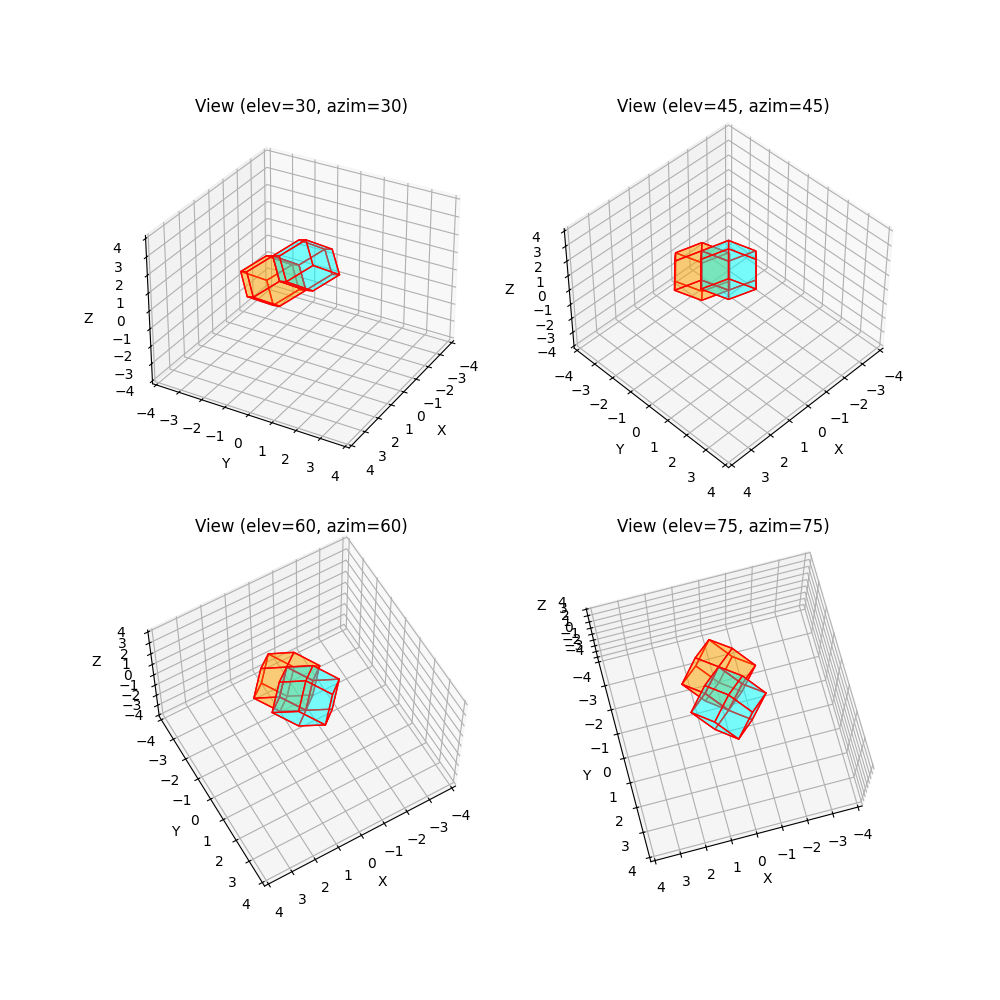

In [135]:
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

def rhombic_dodecahedron_vertices():
    """Return the vertices of a rhombic dodecahedron centered at the origin."""
    vertices = np.array([
        [ 1,  1,  1], # 0
        [ 1,  1, -1], # 1
        [ 1, -1,  1], # 2
        [ 1, -1, -1], # 3
        [-1,  1,  1], # 4
        [-1,  1, -1], # 5
        [-1, -1,  1], # 6
        [-1, -1, -1], # 7
        [ 0,  0,  2], # 8
        [ 0,  0, -2], # 9
        [ 0,  2,  0], # 10
        [ 0, -2,  0], # 11
        [ 2,  0,  0], # 12
        [-2,  0,  0]  # 13
    ])
    return vertices / np.sqrt(2)

def rhombic_dodecahedron_faces():
    """Return the faces of a rhombic dodecahedron using vertex indices."""
    faces = [
        [0, 8, 2, 12], [6, 8, 4, 13], [0, 8, 4, 10], [2, 8, 6, 11], # top 4
        [0, 10, 1, 12], [2, 12, 3, 11], [6, 11, 7, 13], [4, 13, 5, 10], # middle 4
        [1, 9, 3, 12], [7, 9, 5, 13], [1, 9, 5, 10], [3, 9, 7, 11] # bottom 4
    ]
    return faces

def plot_rhombic_dodecahedron(ax, pos=(0,0,0), color='cyan'):
    vertices = rhombic_dodecahedron_vertices()
    faces = rhombic_dodecahedron_faces()

    pos = np.array(pos)

    cartes_pos = pos.copy()
    cartes_pos[0] += pos[1]

    cartes_pos[1] -= pos[0]

    if pos[2] % 2 == 0:
        cartes_pos += np.array([0,-1,0])
        color = 'orange'

    poly3d = [[np.array(vertices[vertice])+np.array(cartes_pos)*np.sqrt(2) for vertice in face] for face in faces]
    ax.add_collection3d(Poly3DCollection(poly3d, facecolors=color, linewidths=1, edgecolors='r', alpha=0.3))

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_zlim([-4, 4])

# Define the angles you want to view the plot from
angles = [(30, 30), (45, 45), (60, 60), (75, 75)]

# Create subplots for each angle
fig = plt.figure(figsize=(10, 10))
for i, angle in enumerate(angles):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    plot_rhombic_dodecahedron(ax)
    plot_rhombic_dodecahedron(ax,pos=(0,0,1))
    ax.view_init(elev=angle[0], azim=angle[1])
    ax.set_title(f'View (elev={angle[0]}, azim={angle[1]})')

plt.show()

interactive(children=(FloatSlider(value=0.1, description='tilt', max=0.30000000000000004, min=-0.1), FloatSlid…

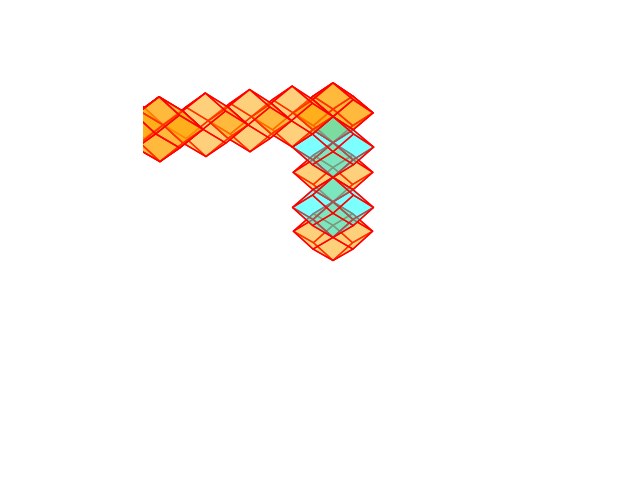

In [136]:
#%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list):
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for pos in pos_list:
        plot_rhombic_dodecahedron(ax, pos)

    plt.axis('off')

    def update(tilt = 0.1, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);


pos_list = []
for i in range(5):
    pos_list.append((0,0,i))

for i in range(5):
    pos_list.append((0,i,4))

for i in range(5):
    pos_list.append((i,4,4))

plot_from_grid(pos_list)